In [39]:
import xarray as xr  
import dask 

from glob import glob 
import os

import numpy as np

import matplotlib.pyplot as plt

import netCDF4 as ncdf


In [42]:
def plot_dpdt(pressure, Title=None):

    Time = np.arange(pressure.shape[1])

    dpdt = pressure[:,1:] - pressure[:,:-1]

    dpdt_mean = dpdt.mean(axis=(2,3))
    dpdt_var  = dpdt.var(axis=(2,3))

    # plot code
    fig, ax = plt.subplots(1, 1, layout='constrained')

    twin1 = ax.twinx()

    real_time = 0.5*(Time[1:] + Time[:-1])*300/3600

    p1, = ax.plot(real_time, dpdt_mean.mean(axis=(0))/100., color='k', label = 'MEAN dp/dt')
    p2, = twin1.plot(real_time, dpdt_var.var(axis=(0))/100., color='r', label = 'VAR dp/dt')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Five minute change in surface pressure (hPa)')
    twin1.set(ylabel="Five minute variance of surface pressure (hPa)")

    for x in [1.0,2.0,3.0,4.0,5.0,6.0]:
        ax.axvline(x, 0, 1, linestyle='--', color='k', linewidth=0.5)

    ax.legend(handles=[p1, p2], loc='upper right')
    ax.set_ylim(-0.2, 0.2)
    
    if Title != None:
        plt.suptitle(Title)
    

In [27]:
def list_drop_variables(path, keep_var='PSFC'):

    tmp_ds = xr.open_dataset(path)
    data_vars = tmp_ds.data_vars
    drop_variables = [v for v in data_vars if v != keep_var]
    tmp_ds.close()

    return drop_variables

In [51]:
# Read data set 

def read_pressure(BASE_PATH, prefix, ens=18, keep_vars='PSFC', model='mpas'):
    
    ens_size = 1 + np.arange(ens)

    for m, i in enumerate(ens_size):   # Collect all file paths for each ensemble member
    
        if model == 'mpas':
            paths = glob(os.path.join(BASE_PATH, f'mem{i:02d}', prefix))
        else:
            paths = glob(os.path.join(BASE_PATH, f'ENS_MEM_{i:d}', prefix))
        
        paths.sort()

        if len(paths) == 0:
            print("\n Problem, files are not found, list is empty\n")
            print(os.path.join(BASE_PATH, f'mem{i:02d}', prefix))
            return
        else:
            print("\n Now processing member:  %d" % i)
    
        if m == 0:  # allocate pressure array from info in ensemble
            
            tmp_ds = xr.open_dataset(paths[0], engine='netcdf4')
            
            data_vars = tmp_ds.data_vars
            drop_variables = [v for v in data_vars if v != keep_vars]
            
            pressure = np.zeros((ens,len(paths),300,300))
            tmp_ds.close()
            print("\n Created pressure array:  P-shape: ", pressure.shape)
        
        for n, path in enumerate(paths):
            #dataset = xr.open_dataset(  path, engine='netcdf4', drop_variables = drop_variables)    
            
            dataset = ncdf.Dataset(path)    

            pressure[m,n] = dataset.variables['PSFC'][...]
            dataset.close()

    return pressure

In [54]:
BASE_PATH = '/scratch/ywang/MPAS/intel/run_dirs/20240516/fcst_filter18/1800/mpassit'

p = read_pressure(BASE_PATH, 'MPASSIT_*', ens=18)


 Now processing member:  1

 Created pressure array:  P-shape:  (18, 73, 300, 300)

 Now processing member:  2

 Now processing member:  3

 Now processing member:  4

 Now processing member:  5

 Now processing member:  6

 Now processing member:  7

 Now processing member:  8

 Now processing member:  9

 Now processing member:  10

 Now processing member:  11

 Now processing member:  12

 Now processing member:  13

 Now processing member:  14

 Now processing member:  15

 Now processing member:  16

 Now processing member:  17

 Now processing member:  18


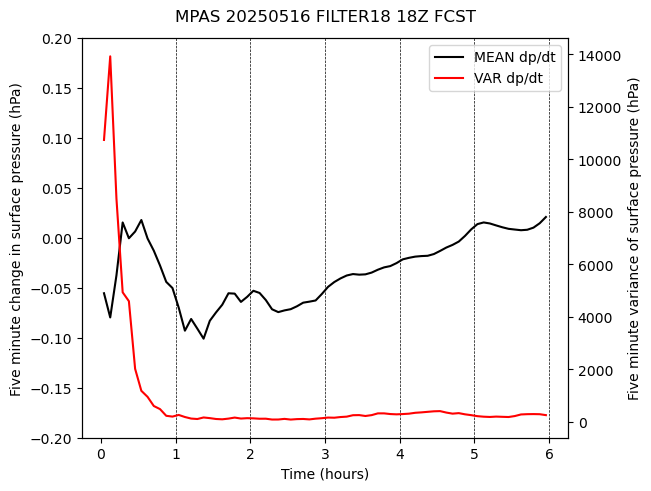

In [55]:
plot_dpdt(p, Title='MPAS 20250516 FILTER18 18Z FCST')

In [52]:
BASE_PATH = '/scratch/tajones/dart/FCST/20240508/1800/'

p = read_pressure(BASE_PATH, 'wrfout_d01*', ens=18, model='wrf')


 Now processing member:  1

 Created pressure array:  P-shape:  (18, 73, 300, 300)

 Now processing member:  2

 Now processing member:  3

 Now processing member:  4

 Now processing member:  5

 Now processing member:  6

 Now processing member:  7

 Now processing member:  8

 Now processing member:  9

 Now processing member:  10

 Now processing member:  11

 Now processing member:  12

 Now processing member:  13

 Now processing member:  14

 Now processing member:  15

 Now processing member:  16

 Now processing member:  17

 Now processing member:  18


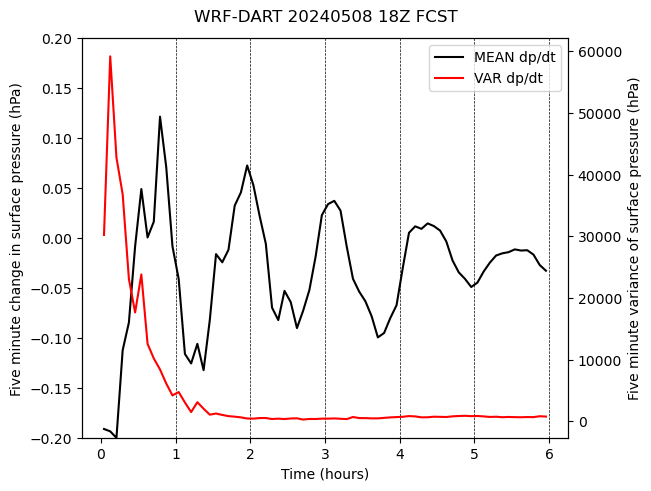

In [53]:
plot_dpdt(p, Title='WRF-DART 20240508 18Z FCST')